<a href="https://colab.research.google.com/github/Alex-So-Ma/Fisica_Computacional_FC_UNAM/blob/main/Tarea_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vinos

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Del archivo extraemos los datos y los separamos entre las etiquetas y los vectores con la información de cada vino. Normalizamos los vectores y dividimos la información entre datos de entrenamiento y datos de prueba.

In [ ]:
data1 = pd.read_csv('wine.data', sep=",")
data2 = data1.to_numpy()
np.random.shuffle(data2) #Pasamos los datos a un array y los reordenamos los datos al azar

data2_labels=np.zeros(len(data2))
for i in range(len(data2)):
  data2_labels[i]=data2[i][0]-1
data2_carac = np.delete(data2, 0, 1) #Creamos un array con la eqtiquetas y los vectores

def normalizeRows(x):
    x_norm = np.linalg.norm(x, axis = 1, keepdims = True)
    x = x / x_norm
    return x
data2_carac = normalizeRows(data2_carac) #Normalizamos los datos

n=142
train_data=data2_carac[:n]
train_labels=data2_labels[:n]
test_data=data2_carac[n:]
test_labels=data2_labels[n:] #Dividimos las etiquetas y vectores en datos de entrenamiento y prueba

##Primer metodo (el usado con mnist)

Como la clasifiación de los datos es parecida a la de la base mnist, intentmos usar el mismo método. Con menos neuronas ya que la información es menor.

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"), #Usamos dos capas densas con 64 neuronas por el tamaño de los vectores
    layers.Dense(3, activation="softmax") #La capa final solo tiene 3 por las tres posibles etiquetas
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]) #Las mismas finciones que para mnist

model.fit(train_data, train_labels, epochs=20, batch_size=128, validation_split=0.2) #Entrenamos la red

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 1.1150 - accuracy: 0.2566 - val_loss: 1.0923 - val_accuracy: 0.4138
Epoch 2/20
1/1 [==============================] - 0s 55ms/step - loss: 1.0933 - accuracy: 0.2566 - val_loss: 1.0991 - val_accuracy: 0.2759
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 1.0835 - accuracy: 0.4336 - val_loss: 1.1046 - val_accuracy: 0.2759
Epoch 4/20
1/1 [==============================] - 0s 72ms/step - loss: 1.0766 - accuracy: 0.4336 - val_loss: 1.1102 - val_accuracy: 0.2759
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 1.0718 - accuracy: 0.4336 - val_loss: 1.1147 - val_accuracy: 0.2759
Epoch 6/20
1/1 [==============================] - 0s 71ms/step - loss: 1.0685 - accuracy: 0.4336 - val_loss: 1.1182 - val_accuracy: 0.2759
Epoch 7/20
1/1 [==============================] - 0s 75ms/step - loss: 1.0658 - accuracy: 0.4336 - val_loss: 1.1220 - val_accuracy: 0.2759
Epoch 8/20
1/1 [=============

Usamos los datos de prueba, aunque ya vimos que la accuracy es muy baja.

In [ ]:
predictions = model.predict(test_data) #Usamos el modelo con los datos de prueba

predictions2=np.zeros(len(predictions))
for i in range(len(predictions)):
  predictions2[i]=predictions[i].argmax()+1
x=predictions2
y=test_labels+1
x-y #Restamos las predicciones y las etiquetas para darnos una idea de donde acerto
    #por el accuracy obtenido, desde un principio ya sabemos que no es un buen modelo

2/2 [==============================] - 0s 5ms/step


array([ 1.,  1.,  1.,  0.,  0., -1., -1.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  1., -1.,  1.,  1.,  0., -1.,  0.,  0.,  0.,
        1.,  0.,  1., -1., -1.,  0., -1.,  1.,  1.,  0.])

Ya que tenemos una cantidad de datos menor, necesitamos un método diferente.

##Validación cruzada

Usamos el método de validación cruzada. Primero definimos el modelo dentro de una función.

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(3, activation="softmax")
    ])
    model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

Usamos una $k=4$ con 1000 épocas.

In [ ]:
k = 4
num_val_samples = len(train_data) // k

num_epochs = 1000
all_acc_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_labels = np.concatenate(
        [train_labels[:i * num_val_samples],
         train_labels[(i + 1) * num_val_samples:]],
        axis=0) #Separamos el conjunto de entrenamiento en datos de entrenamiento y validación, según sea requerido

    model = build_model()
    history = model.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=num_epochs, batch_size=16, verbose=0) #Entrenamos la red
    acc_history = history.history["val_accuracy"]
    all_acc_histories.append(acc_history) #Vamos documentando el accuracy

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


Graficamos el accuracy medio de la validación cruzada a en las épocas.

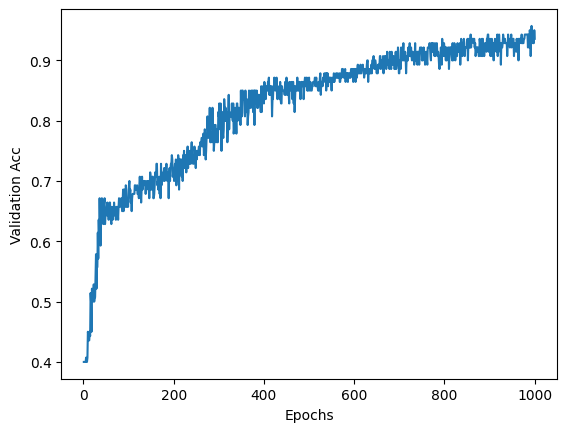

In [ ]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Acc")
plt.show()

A partir de 800 épocas se empieza a tener un modelo adecuado.

###Construcción del modelo

In [ ]:
model = build_model()
model.fit(train_data, train_labels,
          epochs=800, batch_size=16, verbose=0)
test_scc_score, test_acc_score = model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 10ms/step - loss: 0.3046 - accuracy: 0.9167


In [ ]:
test_acc_score

0.9166666865348816

In [ ]:
predictions = model.predict(test_data)
predictions2=np.zeros(len(predictions))
for i in range(len(predictions)):
  predictions2[i]=predictions[i].argmax()+1
x=predictions2
y=test_labels+1
x-y

2/2 [==============================] - 0s 6ms/step


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
        0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

La cantidad de datos no llevo a usar 800 épocas para tener un accuray mayor a 0.9
Esto nos lleva a concluir que tener una buena cantidad de datos es importante.